
### Author : Kalyani Avhale
# Flower Recognition 🌸 
  - Task : Recognize what kind of flower is that?
  - This dataset contains 4242 images of flowers.
  - The pictures are divided into five classes: chamomile, tulip, rose, sunflower, dandelion.
  - For each class there are about 800 photos. Photos are not high resolution, about 320x240 pixels. Photos are not reduced to a single size, they have different proportions!
  
  ###### Dataset : https://www.kaggle.com/alxmamaev/flowers-recognition

In [1]:
!pip install -q split-folders

### Import required libraries and Load the dataset

In [2]:
#import required libraries 
import os
import zipfile
import splitfolders 
import time

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

import tensorflow as tf
import keras
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import  MobileNetV2, ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_input_resnet50
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_input_vgg16
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_input_mobilenetv2

In [3]:
!ls ../input/flowers-recognition/flowers

daisy  dandelion  rose	sunflower  tulip


In [6]:
# Split the Dataset folders into train test val folders
splitfolders.ratio("../input/flowers-recognition/flowers", output="output", seed=100, ratio=(.8, .1, .1), group_prefix=None) 

Copying files: 4317 files [00:04, 958.15 files/s] 


In [7]:
!ls  ./output

test  train  val


In [8]:
#create paths for folders 


daisy_dir = os.path.join('./output/train/daisy')
dandelion_dir = os.path.join('./output/train/dandelion')
rose_dir = os.path.join('./output/train/rose')
sunflower_dir = os.path.join('./output/train/sunflower')
tulip_dir = os.path.join('./output/train/tulip')

#count number of files in each directory
print('Total training Daisy images :',len(os.listdir(daisy_dir)))
print('Total training Dandelion images :',len(os.listdir(dandelion_dir)))
print('Total training Rose images :',len(os.listdir(rose_dir)))
print('Total training Sunflower images :',len(os.listdir(sunflower_dir)))
print('Total training Tulip images :',len(os.listdir(tulip_dir)))

print('\n')
daisy_files = os.listdir(daisy_dir)
dandelion_files = os.listdir(dandelion_dir)
rose_files = os.listdir(rose_dir)
sunflower_files = os.listdir(sunflower_dir)
tulip_files = os.listdir(tulip_dir)

print("Total len of training images",len(daisy_files+dandelion_files+rose_files+sunflower_files+tulip_files))

Total training Daisy images : 611
Total training Dandelion images : 841
Total training Rose images : 627
Total training Sunflower images : 586
Total training Tulip images : 787


Total len of training images 3452


In [9]:
#count of images available in test dataset for each category
print('Total Test Daisy images :',len(os.listdir('output/test/daisy')))
print('Total Test Dandelion images :',len(os.listdir('output/test/dandelion')))
print('Total Test Rose images :',len(os.listdir('output/test/rose')))
print('Total Test Sunflower images :',len(os.listdir('output/test/sunflower')))
print('Total Test Tulip images :',len(os.listdir('output/test/tulip')))

Total Test Daisy images : 77
Total Test Dandelion images : 106
Total Test Rose images : 79
Total Test Sunflower images : 74
Total Test Tulip images : 99


### Visualization

In [10]:
#to plot images get complete paths for images
pic_index = 10

#get paths for some of the immages from each folder
daisy_fewimg = [os.path.join(daisy_dir,fname) for fname in daisy_files[pic_index-10:pic_index]]
dandelion_fewimg = [os.path.join(dandelion_dir,fname) for fname in dandelion_files[pic_index-10:pic_index]]
rose_fewimg = [os.path.join(rose_dir,fname) for fname in rose_files[pic_index-10:pic_index]]
sunflower_fewimg = [os.path.join(sunflower_dir,fname) for fname in sunflower_files[pic_index-10:pic_index]]
tulip_fewimg = [os.path.join(tulip_dir,fname) for fname in tulip_files[pic_index-10:pic_index]]


(333, 500, 3)


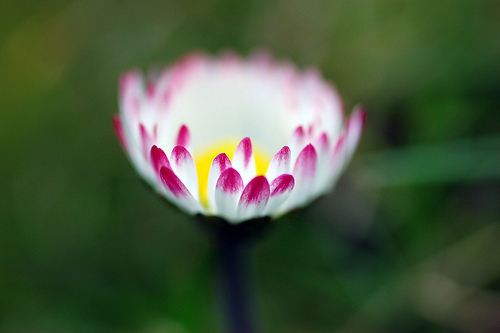

In [11]:
#plot random image 
import PIL.Image as Image

print(cv2.imread(daisy_fewimg[0]).shape)
Image.open(daisy_fewimg[0])

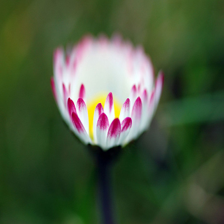

In [12]:
Image.open(daisy_fewimg[0]).resize((224,224))

In [13]:
#function to convert BGR image to RGB
def cvtRGB(img):
    return cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)

In [14]:
#plot smaple of images function
def plot_img(imgpath_list):

  fig, ax = plt.subplots(3,3,figsize=(10,10))
  k = 0
  for j in range(3):
    for i in range(3):
        img = cv2.resize(cv2.imread(imgpath_list[k]),(224,224))
        k=k+1
        ax[i,j].imshow(cvtRGB(img));
        ax[i,j].axis('off');

				Daisy


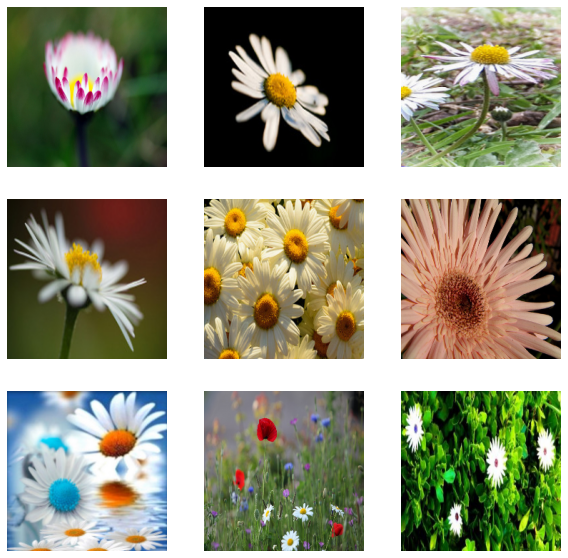

In [15]:
print('\t\t\t\tDaisy')
plot_img(daisy_fewimg)

				Dadelion


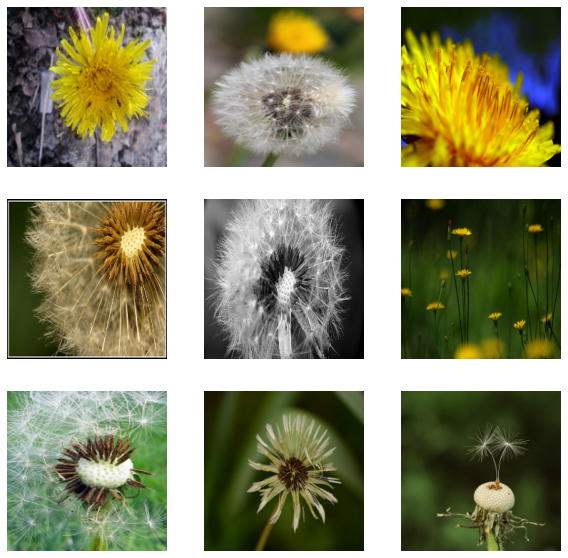

In [16]:
print('\t\t\t\tDadelion')
plot_img(dandelion_fewimg)

				Rose


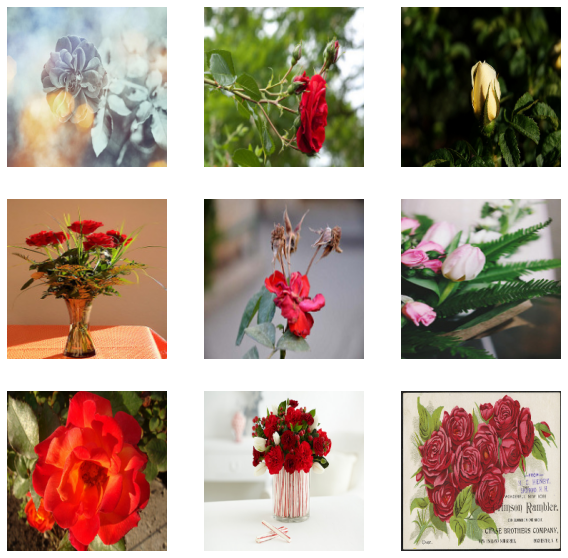

In [17]:
print('\t\t\t\tRose')
plot_img(rose_fewimg)

				Tulip


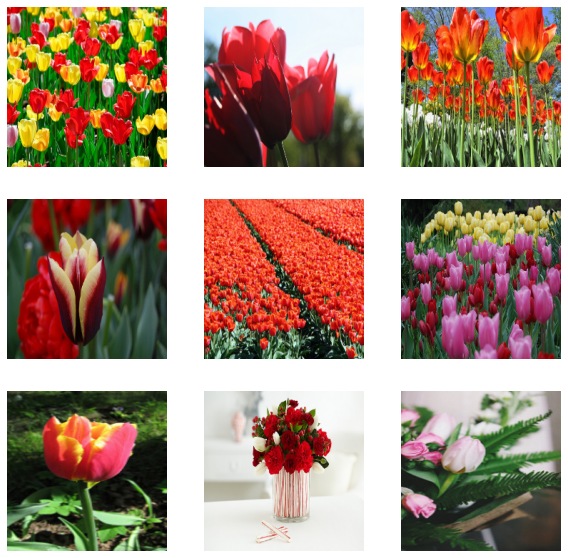

In [18]:
print('\t\t\t\tTulip')
plot_img(tulip_fewimg)

				Sunflower


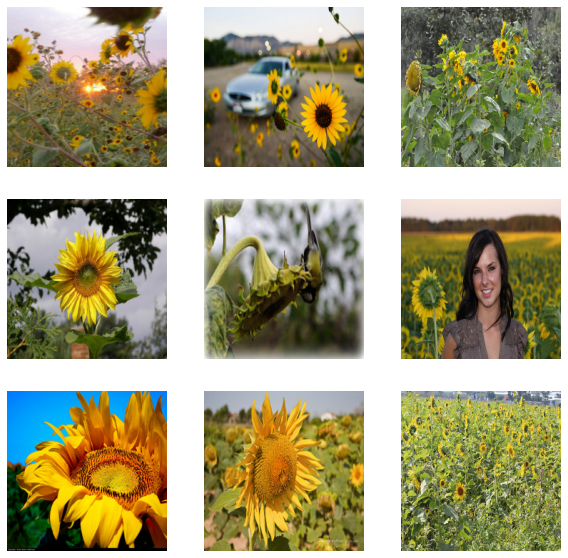

In [19]:
print('\t\t\t\tSunflower')
plot_img(sunflower_fewimg)

Few images has other objects present

### Pre-Processing 

In [20]:
#image Augumentation using ImageDataGenerator on train data 
#Data augmentation is used to increase the size of training set and to get more different images
training_dir = './output/train/'
training_datagen = ImageDataGenerator(
    rescale = 1./255, #normalization
    rotation_range = 40,
    width_shift_range = 0.4,
    height_shift_range = 0.4,
    shear_range = 0.2,
    zoom_range = 0.1,
    fill_mode = 'nearest',
    horizontal_flip = True)

In [21]:
#do not perform augmentation on validation and test data/validation set ,this might mislead the results
validation_dir = './output/val'
validation_datagen = ImageDataGenerator(
    rescale=1./255
)

test_dir = './output/test'
test_datagen = ImageDataGenerator(
    rescale=1./255
)

In [22]:
#flow_from_directory() method allows you to read the images directly from the directory and augment them while the neural network model is learning on the training data.
train_generator = training_datagen.flow_from_directory(
    training_dir,
    target_size = (224,224), #rescale images to fixed size
    class_mode = 'categorical',
    batch_size = 32
)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size = (224,224),
    class_mode = 'categorical',
    batch_size = 32
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (224,224),
    class_mode = 'categorical',
    batch_size = 32
)

Found 3452 images belonging to 5 classes.
Found 430 images belonging to 5 classes.
Found 435 images belonging to 5 classes.


In [ ]:
#tf.keras.backend.clear_session()

### Model Building

In [23]:
# Build CNN sequential model and train from scratch 
def model_from_scratch():
  #Build model
  model = tf.keras.models.Sequential([
              tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (224,224,3)),
              tf.keras.layers.MaxPool2D(2,2),
              tf.keras.layers.Dropout(0.5),
              tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
              tf.keras.layers.MaxPool2D(2,2),
              tf.keras.layers.Dropout(0.5),
              tf.keras.layers.Conv2D(128, (3,3), activation = 'relu'),
              tf.keras.layers.MaxPool2D(2,2),
              tf.keras.layers.Dropout(0.5),
              tf.keras.layers.Flatten(),
              tf.keras.layers.Dropout(0.5),
              tf.keras.layers.Dense(512, activation = 'relu'),
              tf.keras.layers.Dense(5, activation = 'softmax')
  ])

  #model compilation
  model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy']
            )
  
  return model

model_from_scratch().summary() #Model Summary

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       7

In [25]:
#fit model to train dataset 
epochs = 25
start = time.time()

model = model_from_scratch()
history1 = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=5,
                    verbose=2
                    )

end = time.time()
duration = end - start
print ('\n Model built from scratch training took %0.2f seconds (%0.1f minutes) to train for %d epochs'%(duration, duration/60, epochs) )

Epoch 1/25
108/108 - 46s - loss: 2.3901 - accuracy: 0.2320 - val_loss: 1.6012 - val_accuracy: 0.2313
Epoch 2/25
108/108 - 46s - loss: 1.6014 - accuracy: 0.2436 - val_loss: 1.5968 - val_accuracy: 0.2313
Epoch 3/25
108/108 - 45s - loss: 1.5314 - accuracy: 0.2879 - val_loss: 1.3737 - val_accuracy: 0.4250
Epoch 4/25
108/108 - 47s - loss: 1.3713 - accuracy: 0.4027 - val_loss: 1.2960 - val_accuracy: 0.4688
Epoch 5/25
108/108 - 45s - loss: 1.2606 - accuracy: 0.4366 - val_loss: 1.0913 - val_accuracy: 0.5312
Epoch 6/25
108/108 - 46s - loss: 1.2013 - accuracy: 0.4757 - val_loss: 1.2084 - val_accuracy: 0.4437
Epoch 7/25
108/108 - 46s - loss: 1.1865 - accuracy: 0.4948 - val_loss: 1.1990 - val_accuracy: 0.4000
Epoch 8/25
108/108 - 46s - loss: 1.1134 - accuracy: 0.5385 - val_loss: 1.1241 - val_accuracy: 0.5063
Epoch 9/25
108/108 - 45s - loss: 1.1178 - accuracy: 0.5385 - val_loss: 1.0513 - val_accuracy: 0.6125
Epoch 10/25
108/108 - 46s - loss: 1.0682 - accuracy: 0.5652 - val_loss: 0.9098 - val_accura

##### val_accuracy:0.6625
##### val_loss : 0.8049 
##### Model has been trained well with 66% accuracy , but will try increasing it further with Transfer learning

#### Visualize model performance

In [26]:
#function to get accuracy and loss from history 
def get_history_data(history):
    
  train_acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  return train_acc,val_acc,train_loss,val_loss

In [27]:
train_acc,val_acc,train_loss,val_loss = get_history_data(history1)

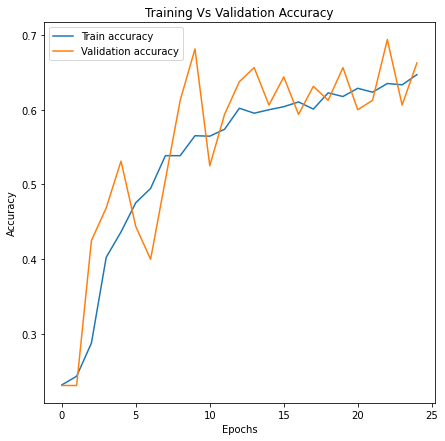

In [28]:
#plot Accuracy graph
epochs = range(len(train_acc))
plt.figure(figsize=(7,7));
plt.plot(epochs,train_acc,label ='Train accuracy');
plt.plot(epochs,val_acc,label ='Validation accuracy');
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend();
plt.title('Training Vs Validation Accuracy');

###### the flucation on validation accuarcy is nothing but overfitting , which can be probaly because of the noise present in the data

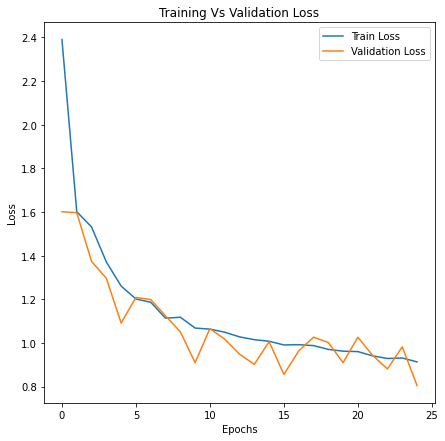

In [29]:
#plot validation graph
plt.figure(figsize=(7,7));
plt.plot(epochs,train_loss,label ='Train Loss');
plt.plot(epochs,val_loss,label ='Validation Loss');
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend();
plt.title('Training Vs Validation Loss');

In [30]:
model.save('./model_from_stratch.h5')

In [31]:
#check how model performs on test data(unseen data)
model.evaluate(test_generator)

14/14 [==============================] - 2s 107ms/step - loss: 0.8467 - accuracy: 0.7034


[0.8466726541519165, 0.7034482955932617]

**loss: 0.8467 - accuracy: 0.7034** 

**Model has performed well on test data**

## Transfer Learning : Using Pre-trained model to improve model performance

In [ ]:
#tf.keras.backend.clear_session()

### VGG16 : 

In [ ]:
#use VGG16 pre-trained model
def create_model_from_VGG16():
   
    model = VGG16(weights = "imagenet", include_top=False, input_shape = (224,224, 3))
    
    # don't train existing weights 
    for layer in model.layers:
      layer.trainable = False

    #Adding custom Layers 
    x = model.output
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(128, activation="relu")(x)
    #x = keras.layers.Dropout(0.5)(x)
    #x = keras.layers.Dense(1024, activation="relu")(x)
    predictions = keras.layers.Dense(5, activation="softmax")(x)
    
    # creating the final model 
    final_model = keras.models.Model(inputs = model.input, outputs = predictions)
    
    final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
    
    return final_model

create_model_from_VGG16().summary()

In [ ]:
epochs = 10
start = time.time()

model_from_vgg16 = create_model_from_VGG16()
history2 = model_from_vgg16.fit(train_generator,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=5,
                    verbose=2
                     )

end = time.time()
duration = end - start
print ('\n model from trained with VGG16 took %0.2f seconds (%0.1f minutes) to train for %d epochs'%(duration, duration/60, epochs) )

##### results
**loss: 0.5707 - accuracy: 0.7871 - val_loss: 0.6541 - val_accuracy: 0.7875**
Better than the perevious model (model built from scratch)

In [ ]:
pd.DataFrame(history2.history).plot(figsize=(8,5))
plt.show()

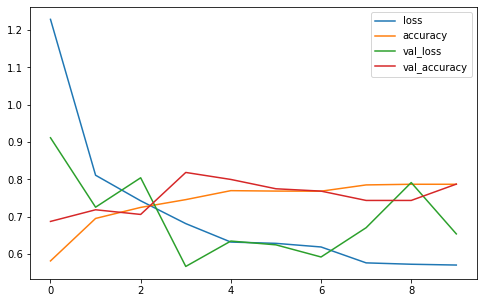

In [ ]:
model.save('./model_from_VGG16.h5')

In [ ]:
model_from_vgg16.evaluate(test_generator)

**model performance on test data:**
**loss: 0.5357 - accuracy: 0.8276**

### ResNet50

In [ ]:
#tf.keras.backend.clear_session()

In [ ]:
#use ResNet50 pre-trained model
def create_model_from_ResNet50():
   
    model = ResNet50(weights = "imagenet", include_top=False, input_shape = (224,224, 3))
    
    # don't train existing weights
    for layer in model.layers:
      layer.trainable = False

    #Adding custom Dense Layers 
    x = model.output
    x = keras.layers.Flatten()(x)
    #x = keras.layers.Dense(128, activation="relu")(x)
    #x = keras.layers.Dropout(0.5)(x)
    #x = keras.layers.Dense(512, activation="relu")(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    predictions = keras.layers.Dense(5, activation="softmax")(x)
    
    # creating the final model 
    final_model = keras.models.Model(inputs = model.input, outputs = predictions)
    
    final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
    
    return final_model

create_model_from_ResNet50().summary()

In [ ]:
#epochs = 10
#start = time.time()

#model_resNet50 = create_model_from_ResNet50()
#history3 = model_resNet50.fit(train_generator,
#                    epochs=epochs,
#                    validation_data=validation_generator,
#                    validation_steps=5,
#                    verbose=2
#                     )

#end = time.time()
#duration = end - start
#print ('\n model from trained from ResNet50 took %0.2f seconds (%0.1f minutes) to train for %d epochs'%(duration, duration/60, epochs) )

In [ ]:
#model_resNet50.evaluate(test_generator)

#### MobileNetV2

In [ ]:
#using preprocess function of pretarined model so that model is not overfitted and trained properly
training_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_mobilenetv2)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_mobilenetv2)

train_generator = training_datagen.flow_from_directory(
    training_dir,
    target_size = (224,224),
    class_mode = 'categorical',
    batch_size = 32
)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size = (224,224),
    class_mode = 'categorical',
    batch_size = 32
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (224,224),
    class_mode = 'categorical',
    batch_size = 32
)

In [ ]:
#use Rmobilenetv2 pre-trained model
def create_model_from_mobilenetv2():
   
    model = MobileNetV2(weights = "imagenet", include_top=False, input_shape = (224,224, 3))
    
    # don't train existing weights
    for layer in model.layers:
      layer.trainable = False

    #Adding custom Dense Layers 
    x = model.output
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(128, activation="relu")(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(512, activation="relu")(x)
    predictions = keras.layers.Dense(5, activation="softmax")(x)
    
    # creating the final model 
    final_model = keras.models.Model(inputs = model.input, outputs = predictions)
    
    final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
    
    return final_model

create_model_from_mobilenetv2().summary()

In [ ]:
epochs = 10
start = time.time()

model_mobilenetV2 = create_model_from_mobilenetv2()
history4 = model_mobilenetV2.fit(train_generator,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=5,
                    verbose=2
                     )

end = time.time()
duration = end - start
print ('\n model from trained from MobileNetV2 took %0.2f seconds (%0.1f minutes) to train for %d epochs'%(duration, duration/60, epochs) )

##### Model Performance :
**loss: 0.4698 - accuracy: 0.8473 - val_loss: 0.9422 - val_accuracy: 0.7875**

In [ ]:
model_mobilenetV2.evaluate(test_generator)

##### Performance on Test Data:
**loss: 0.7838 - accuracy: 0.8483**

### Test model by uploading random images and check results

In [ ]:
!pip install -q gradio

In [ ]:
import gradio as gr 
import tensorflow as tf
import numpy as np
import requests
from keras.preprocessing import image

In [ ]:
#used model trained using vgg16 as it performed well on both train and test data
labels = ['Daisy','Dadelion','Rose','Sunflower','Tulip'] #classes

def classify_image(inp):
  img = inp.reshape((-1,224,224,3)) #reshape input image
  prediction = model_from_vgg16.predict(img).flatten() #prediction
  return {labels[i]: float(prediction[i]) for i in range(5)} #return classes

image = gr.inputs.Image(shape=(224, 224))
label = gr.outputs.Label(num_top_classes=1)

gr.Interface(fn=classify_image, inputs=image, outputs=label, capture_session=True).launch(debug=True,share=True)

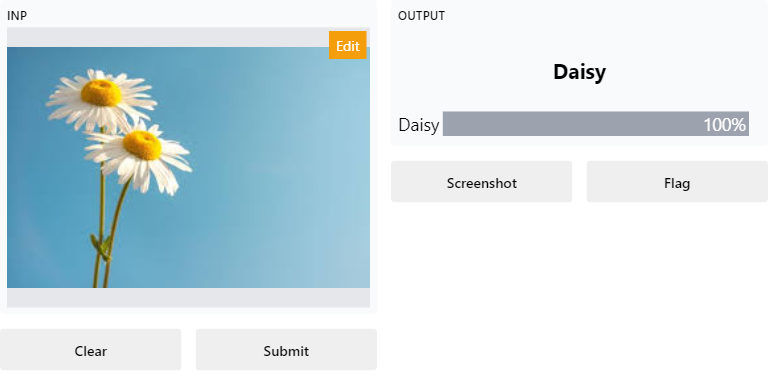

**Actual : Daisy**

**Prediction: Daisy**

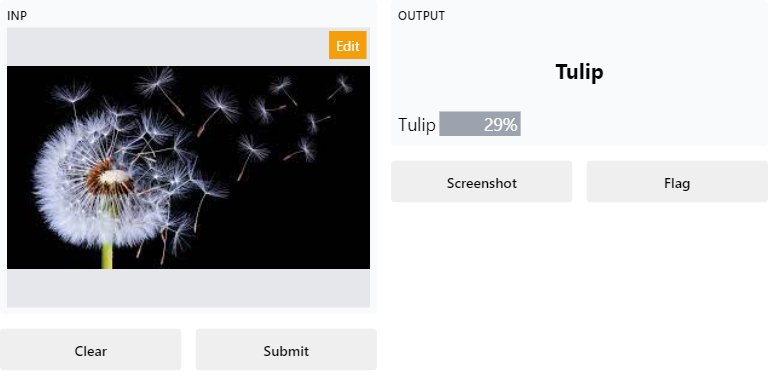

**Actual : Dadelion**

**Prediction : Daisy**


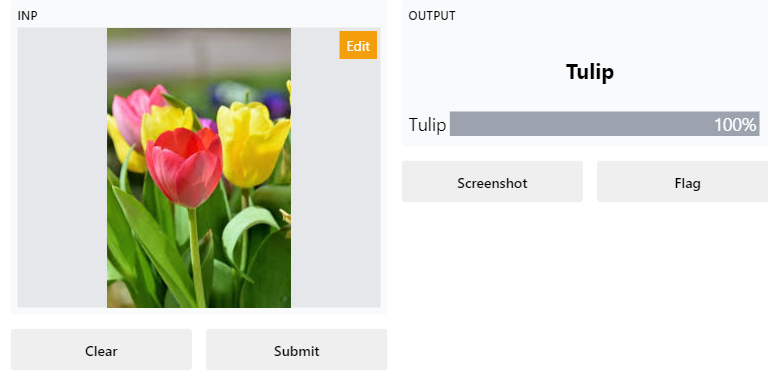

**Actual : Tulip**

**Prediction : Tulip**


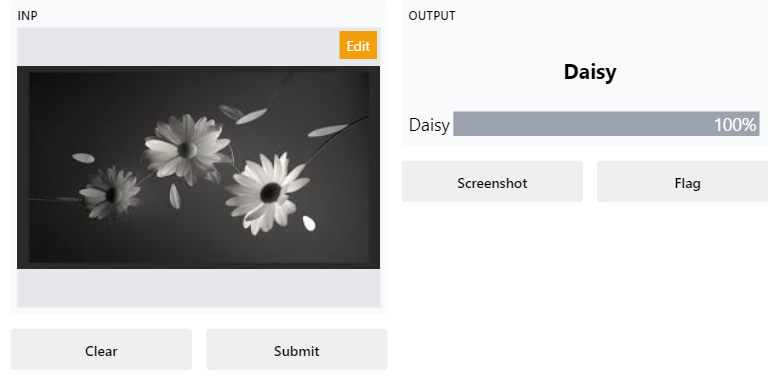

**Actual : Daisy**

**Prediction : Daisy**

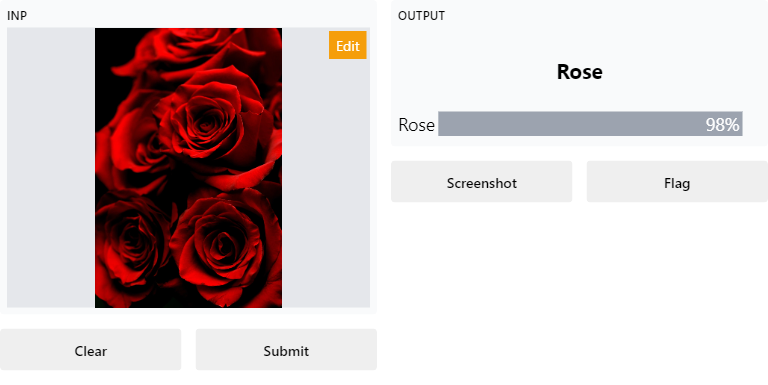

**Actual : Rose**

**Prediction : Rose**

**Please upvote my notebook if you found it informative and helpful. If you want to give any suggestions and queries regarding notebook please feel free to mention it in comments**